#Classification

$$
\renewcommand{\like}{{\cal L}}
\renewcommand{\loglike}{{\ell}}
\renewcommand{\err}{{\cal E}}
\renewcommand{\dat}{{\cal D}}
\renewcommand{\hyp}{{\cal H}}
\renewcommand{\Ex}[2]{E_{#1}[#2]}
\renewcommand{\x}{{\mathbf x}}
\renewcommand{\v}[1]{{\mathbf #1}}
$$

#Table of Contents
* [Classification](#Classification)
	* [Using `sklearn`: The heights and weights example](#Using-sklearn:-The-heights-and-weights-example)
	* [How to Classify](#How-to-Classify)
	* [The ATM Camera example](#The-ATM-Camera-example)
		* [The curse of dimensionality: Feature engineering](#The-curse-of-dimensionality:-Feature-engineering)
	* [Classifying in a reduced feature space with kNN](#Classifying-in-a-reduced-feature-space-with-kNN)
		* [Error against complexity (k), and cross-validation](#Error-against-complexity-%28k%29,-and-cross-validation)
		* [Setting up some code](#Setting-up-some-code)
		* [As before, cross-validation](#As-before,-cross-validation)
			* [Evaluation](#Evaluation)
	* [Logistic Regression](#Logistic-Regression)
		* [The probabilistic interpretaion](#The-probabilistic-interpretaion)
		* [Maximizing the probability of the training set.](#Maximizing-the-probability-of-the-training-set.)
		* [Discriminative classifier](#Discriminative-classifier)
	* [The multiple risks in classification](#The-multiple-risks-in-classification)
	* [Discriminants: sometime there is no probabilities](#Discriminants:-sometime-there-is-no-probabilities)


We turn our attention to **classification**[^classification]. Classification tries to predict, which of a small set of classes, a sample in a population belongs to. Mathematically, the aim is to find $y$, a **label** based on knowing a feature vector $\x$. For instance, consider predicting gender from seeing a person's face, something we do fairly well as humans. To have a machine do this well, we would typically feed the machine a bunch of images of people which have been labelled "male" or "female" (the training set), and have it learn the gender of the person in the image. Then, given a new photo, the algorithm learned returns us the gender of the person in the photo.

There are different ways of making classifications. One idea is shown schematically in the image below, where we find a line that divides "things" of two different types in a 2-dimensional feature space.

![Splitting using a single line](images/onelinesplit.png)



In [3]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from PIL import Image

In [4]:
c0=sns.color_palette()[0]
c1=sns.color_palette()[1]
c2=sns.color_palette()[2]

In [5]:
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, cdiscrete=cmap_bold, alpha=0.1, psize=10, zfunc=False, predicted=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if zfunc:
        p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
        p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        Z=zfunc(p0, p1)
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    ZZ = Z.reshape(xx.shape)
    if mesh:
        plt.pcolormesh(xx, yy, ZZ, cmap=cmap_light, alpha=alpha, axes=ax)
    if predicted:
        showtr = clf.predict(Xtr)
        showte = clf.predict(Xte)
    else:
        showtr = ytr
        showte = yte
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=showtr-1, cmap=cmap_bold, s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    ax.scatter(Xte[:, 0], Xte[:, 1], c=showte-1, cmap=cmap_bold, alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

In [6]:
def points_plot_prob(ax, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, cdiscrete=cmap_bold, ccolor=cm, psize=10, alpha=0.1):
    ax,xx,yy = points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=False, colorscale=colorscale, cdiscrete=cdiscrete, psize=psize, alpha=alpha, predicted=True) 
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ccolor, alpha=.2, axes=ax)
    cs2 = plt.contour(xx, yy, Z, cmap=ccolor, alpha=.6, axes=ax)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14, axes=ax)
    return ax 

##Using `sklearn`: The heights and weights example

We'll use a dataset of heights and weights of males and females to hone our understanding of classifiers. We load the data into a dataframe and plot it.

In [7]:
dflog=pd.read_csv("data/01_heights_weights_genders.csv")
dflog.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


Remember that the form of data we will use always is

![dataform](images/dataform.jpg)

with the "response" as a plain array

`[1,1,0,0,0,1,0,1,0....]`.

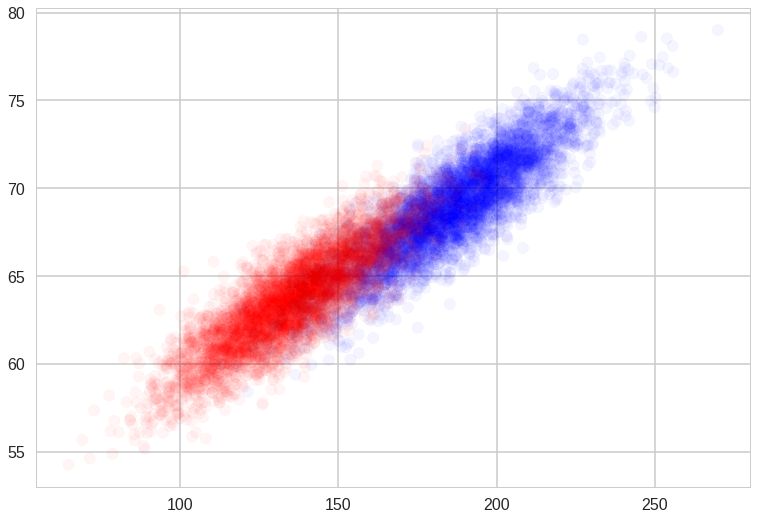

In [19]:
plt.scatter(dflog.Weight, dflog.Height, c=[cm_bright.colors[i] for i in dflog.Gender=="Male"], alpha=0.04);

In [20]:
#from cs109 hw3, 2013
from sklearn.cross_validation import KFold
from sklearn.metrics import accuracy_score

def cv_score(clf, x, y, score_func=accuracy_score):
    result = 0
    nfold = 5
    for train, test in KFold(y.size, nfold): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf.predict(x[test]), y[test]) # evaluate score function on held-out data
    return result / nfold # average

/home/csc/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [21]:
from sklearn.cross_validation import train_test_split
Xlr, Xtestlr, ylr, ytestlr = train_test_split(dflog[['Height','Weight']].values, (dflog.Gender=="Male").values)

In [22]:
#the grid of parameters to search over
Cs = [0.001, 0.1, 1, 10, 100]
from sklearn.linear_model import LogisticRegression
max_score = 0

for C in Cs:
        clf = LogisticRegression(C=C)
        score = cv_score(clf, Xlr, ylr)

        if score > max_score:
            max_score = score
            best_C =C
print max_score, best_C

0.919733333333 0.1


In [23]:
clfl=LogisticRegression(C=best_C)
clfl.fit(Xlr, ylr)
ypred=clfl.predict(Xtestlr)
accuracy_score(ypred, ytestlr)

0.91879999999999995

In [24]:
from sklearn.grid_search import GridSearchCV
clfl2=LogisticRegression()
parameters = {"C": [0.0001, 0.001, 0.1, 1, 10, 100]}
fitmodel = GridSearchCV(clfl2, param_grid=parameters, cv=5, scoring="accuracy")
fitmodel.fit(Xlr, ylr)
fitmodel.best_estimator_, fitmodel.best_params_, fitmodel.best_score_, fitmodel.grid_scores_

/home/csc/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


(LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 {'C': 0.1},
 0.9196,
 [mean: 0.91720, std: 0.00647, params: {'C': 0.0001},
  mean: 0.91893, std: 0.00627, params: {'C': 0.001},
  mean: 0.91960, std: 0.00613, params: {'C': 0.1},
  mean: 0.91960, std: 0.00613, params: {'C': 1},
  mean: 0.91960, std: 0.00613, params: {'C': 10},
  mean: 0.91960, std: 0.00613, params: {'C': 100}])

In [25]:
clfl2=LogisticRegression(C=fitmodel.best_params_['C'])
clfl2.fit(Xlr, ylr)
ypred2=clfl2.predict(Xtestlr)
accuracy_score(ypred2, ytestlr)

0.91879999999999995

##How to Classify

Earlier, we used a squared error loss function along with Empirical Risk Minimization (ERM) to carry out regression. The idea there was to calculate this risk on the training set and minimize it. Then the hope was that on the population, or any testing set representative of it, the out-of-sample risk was similar in size to the in-sample training risk, and thus small.

What might be an appropriate risk for classification? One immediately comes to mind: the fraction of misclassified samples. 

For each sample this is equivalent to choosing the 1-0 loss:

$$l = \mathbf{1}_{h \ne y}.$$

where $h$ is the classification **decision** we make (for regression we used $l = (h-y)^2$). The symbol $\mathbf{1}$ means that if $h$ is not equal to the "true" value of the point $y$, penalize by 1. Then the risk is:

$$ R_{\cal{D}}(h(x)) = \frac{1}{N} \sum_{y_i \in \cal{D}} l = \frac{1}{N} \sum_{y_i \in \cal{D}} \mathbf{1}_{h \ne y_i} $$

Thus if 5 out of 50 samples are misclassified, then the risk is 0.1. This of course means that 90% of the samples are correctly classified. This number is called the **accuracy score** or **utility**:

$$ U_{\cal{D}}(h(x))  = \frac{1}{N} \sum_{y_i \in \cal{D}} \mathbf{1}_{h = y_i} $$


##The ATM Camera example

Imagine that you are tasked whith making a smart ATM camera which can distinguish between dollar notes and checks. You want to make sure that dollars are not classified as checks, and that checks are not classified as dollars.

You are given a set of 87 images of checks and dollars, each of which have been scaled to 322 X 137 pixels, and where each pixel has 3 color channels.

In [26]:
data=np.load("data/imag.pix.npy")
y=np.load("data/imag.lbl.npy")
STANDARD_SIZE = (322, 137)#standardized pixels in image.
data.shape, y.shape

((87, 132342), (87,))

In [27]:
def get_image(mat):
    size = STANDARD_SIZE[0]*STANDARD_SIZE[1]*3
    r,g,b = mat[0:size:3], mat[1:size:3],mat[2:size:3]
    rgbArray = np.zeros((STANDARD_SIZE[1],STANDARD_SIZE[0], 3), 'uint8')#3 channels
    rgbArray[..., 0] = r.reshape((STANDARD_SIZE[1], STANDARD_SIZE[0]))
    rgbArray[..., 1] = b.reshape((STANDARD_SIZE[1], STANDARD_SIZE[0]))
    rgbArray[..., 2] = g.reshape((STANDARD_SIZE[1], STANDARD_SIZE[0]))
    return rgbArray

def display_image(mat):
    with sns.axes_style("white"):
        plt.imshow(get_image(mat))
        plt.xticks([])
        plt.yticks([])

We diaplay some of the images that we have:

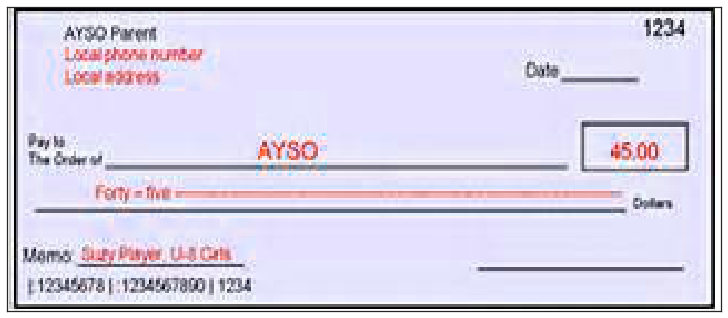

In [28]:
display_image(data[5])

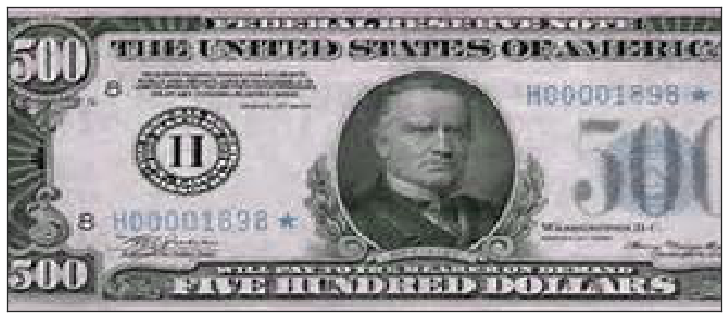

In [29]:
display_image(data[50])

What do you think are some of the aspects of these images that will help us distinguish checks from dollars?

### The curse of dimensionality: Feature engineering

The first thing that you notice is that you have many many features: to be precise, $322 x 137 x 3 = 136452$ of them. This is a lot of features! Having too many features can lead to overfitting.

You have seem this before! Remember when we did the polynomial regression? When we tried to find fits in $\hyp_1$, there were two features, the constant, and $x$. In $\hyp_2$, there are 3: the constant, $x$, and $x^2$. When we get to $\hyp_{20}$, there are 21: the constant, and 20 powers of x. And then we saw how regularization tried to eliminate some of these powers by sending their co-efficients in the polynomial very close to 0, thus reducing the number of features we had.

Another way to look at this problem is the following: we have 85 data points, but 136452 features; that is, way more features than data points. Thus there is a high chance that a few attributes will correlate with $y$ purely coincidentally!
[^Having lots of images, or "big-data" helps in combatting overfitting!]

We need to do something similar to what happened in the regularized regression here! We will engage in some *a-priori* feature selection that will reduce the dimensionality of the problem. The idea we'll use here is something called **Principal Components Analysis**, or PCA.

PCA is an unsupervized learning technique. The basic idea behind PCA is to rotate the co-ordinate axes of the feature space. We first find the direction in which the data varies the most. We set up one co-ordinate axes along this direction, which is called the first principal component. We then look for a perpendicular direction in which the data varies the second most. This is the second principal component. The diagram illustrates this process. There are as many principal components as the feature dimension: all we have done is a rotation.

![pcanim](images/pcanim.gif)

(diagram taken from http://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues which also has nice discussions)

How does this then achieve feature selection? We decide on a threshold of variation; once the variation in a particular direction falls below a certain number, we get rid of all the co-ordinate axes after that principal component. For example, if the variation falls below 10% after the third axes, and we decide that 10% is an acceptable cutoff, we remove all domensions from the fourth dimension onwards. In other words, we took our higher dimensional problem and projected it onto a 3 dimensional **subspace**.

We do not have to do this dimensionality reduction unsupervized. Indeed, you will see some supervized dimensionality reduction in the homework.

These two ideas illustrate one of the most important reasons that learning is even feasible: we believe that **most datasets, in either their unsupervized form $\{\v{x\}}$, or their supervized form $\{y, \v{x}\}$, live on a lower dimensional subspace**. If we can find this subspace, we can then hope to find a methodd which rerpectively separates or fits the data.

Here we'll continue to focus on PCA. We'll reduce our dimensionality from 136452 to 60. We choose 60 as a large apriori number: we dont know if the variation in the data will have gone below a reasonable threshold by then. Notice that we use `fit_transform` in the `sklearn` API which takes the original 87 rows x 136452 columns dimensional data `data` and transforms it to a 87 x 90 data matrix `X`.

In [46]:
from sklearn.decomposition import PCA
pca = PCA(n_components=60)
X = pca.fit_transform(data)

In [31]:
print pca.explained_variance_ratio_.sum()

0.942277128837


The explained variance ratio `pca.explained_variance_ratio_` tells us how much of the variation in the features is explained by these 60 features. When we sum it up over the features, we see that 94% is explained: good enough to go down to a 60 dimensional space from a 136452 dimensional one!

We can see the individual varainces as we increase the dimensionality:

In [21]:
pca.explained_variance_ratio_*100

array([ 35.92596698,   6.29318801,   4.10778347,   3.11950952,
         2.81695972,   2.28831619,   2.10127949,   1.87404975,
         1.73264637,   1.53023773,   1.42159671,   1.318394  ,
         1.24701539,   1.16381841,   1.09958324,   1.06073157,
         1.00743046,   0.98023869,   0.96055948,   0.91535856,
         0.90185612,   0.85213309,   0.8367458 ,   0.79692356,
         0.75489846,   0.72505562,   0.70821781,   0.6796765 ,
         0.66092535,   0.64772084,   0.62739233,   0.59477344,
         0.58303101,   0.57450926,   0.57278186,   0.55261734,
         0.53858717,   0.53343191,   0.51665709,   0.49343182,
         0.48594565,   0.47762236,   0.47284194,   0.45620017,
         0.44417076,   0.44004494,   0.4346039 ,   0.42800383,
         0.42195733,   0.4100348 ,   0.40554006,   0.39424777,
         0.38943727,   0.38311261,   0.37925514,   0.36341299,
         0.36062508,   0.3497255 ,   0.34022686,   0.33491379])

The first dimension accounts for 35% of the variation, the second 6%, and it goes steadily down from there.

Let us create a dataframe with these 60 features labelled pc1,pc2...,pc60 and the labels of the sample:

In [32]:
df = pd.DataFrame({"y":y, "label":np.where(y==1, "check", "dollar")})
for i in range(pca.explained_variance_ratio_.shape[0]):
    df["pc%i" % (i+1)] = X[:,i]
df.head()

,label,y,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16,pc17,pc18,pc19,pc20,pc21,pc22,pc23,pc24,pc25,pc26,pc27,pc28,pc29,pc30,pc31,pc32,pc33,pc34,pc35,pc36,pc37,pc38,pc39,pc40,pc41,pc42,pc43,pc44,pc45,pc46,pc47,pc48,pc49,pc50,pc51,pc52,pc53,pc54,pc55,pc56,pc57,pc58,pc59,pc60
0,check,1,-22536.362571,-2428.344152,-2133.776429,-328.321715,-1065.249615,79.743511,-425.060642,622.474138,-2490.020079,-858.684458,-1072.790257,277.605847,-1117.258479,712.074432,-788.762790,414.060358,-198.304918,471.948529,-429.253918,-610.179963,-588.737000,-264.610050,-987.379304,950.973176,1042.513193,567.919471,-38.871045,-109.665570,-528.318328,564.716421,-633.870434,77.126979,-776.966601,1259.257824,-548.228753,-121.538983,519.650548,259.943574,-253.763269,76.159307,-337.170317,777.000868,742.128005,-387.624446,484.489157,180.585945,-24.082417,300.155126,-755.212247,-589.036029,-370.265428,119.742626,340.476877,-142.021976,438.322730,-337.892985,-208.563754,-220.954057,-314.098236,671.328173
1,check,1,-22226.658685,-709.255993,-288.826979,-1300.626024,-792.097837,217.405478,1076.707292,-2115.127858,-875.216313,-1125.124007,-343.492241,-42.746602,547.950534,356.055733,-1763.113026,-373.507051,809.583793,293.283733,-941.835234,154.888167,-1123.081650,510.114291,-816.818243,717.172328,290.324484,-119.574569,811.147542,1140.457207,-375.393841,141.472226,-842.188765,588.675732,283.304276,180.342425,-673.941438,-691.061778,-69.184105,-229.110930,-181.466933,-429.970759,56.132449,-60.679334,761.198194,77.399112,385.938753,-142.266098,246.179565,533.355200,898.648302,127.571706,-372.162901,-135.806108,7.841745,457.718065,-165.496965,-313.226363,154.558149,112.267304,-146.046122,571.006720
2,check,1,-17364.260784,-4252.027411,793.801691,-1362.046879,-374.238591,3142.070192,2514.170519,1443.836094,-120.818197,-419.824442,-2083.267299,1718.371562,-723.913551,-1241.418252,-312.235736,-1060.607462,1384.000494,-800.693319,-2598.427276,-881.522177,3385.242885,-387.632450,-3416.628580,1335.342325,-4741.582136,1031.800847,2201.510496,-691.299621,1358.584559,-2130.960900,-626.485719,1747.424043,1719.952773,-3163.068146,-937.932800,2032.009379,-2876.143435,3199.675666,840.725349,198.585234,1360.844956,-4223.037199,2771.181963,1392.015204,981.565308,-795.109336,-410.887285,-1435.089406,44.294007,-3161.535261,-2349.559400,-1881.495526,1470.783092,-979.908263,2366.804929,-767.026818,1555.621939,372.130599,-1319.530166,-1511.957719
3,check,1,-22847.256200,-900.590254,577.209447,-180.352025,-733.117967,-107.993722,1441.880071,-1069.638101,845.274160,-1389.364761,1470.159134,-722.432020,-581.720880,-259.237029,935.242380,164.158605,-300.061534,870.867987,-168.917841,1225.483365,555.825017,-173.699334,-335.655730,-395.174398,-895.194698,195.998222,1382.479466,99.802888,-248.619524,-487.696592,-113.414725,34.217407,-24.136136,772.402577,-131.915947,569.984792,535.189164,316.684025,93.364999,-408.757790,1018.401564,-467.309326,-1199.387281,497.918151,275.270159,627.004399,-1109.454165,-372.932858,-659.692857,-1375.601580,68.652360,226.903254,95.346255,158.851281,167.976296,137.598436,-827.517984,-924.691218,223.559976,-506.731010
4,check,1,-15868.672594,3259.490865,506.800450,-919.645849,2166.552963,-981.537535,-1669.626131,-391.263187,1735.270958,163.650233,-1626.360381,-557.627982,-862.812341,1723.544588,946.061694,-1130.799878,2143.450406,768.284117,-1097.803845,604.447849,-26.662801,85.169345,-503.620202,1115.002786,320.245073,-1217.452124,-717.811073,-713.566399,-147.321269,-909.829448,998.894724,-3665.471144,2320.805483,-3182.078491,-1034.361282,-2035.972940,1947.634831,2040.444607,2596.242778,-403.117132,542.303926,877.619672,1496.187689,-1304.618592,-219.752718,901.104530,335.765203,1213.408206,3162.787690,1400.410145,-1552.570547,-2324.224580,309.318956,3174.334801,-2691.282052,1233.429001,467.324807,-1863.260524,-2328.764199,566.394443


Lets see what these principal components look like:

In [40]:
pcat = PCA(n_components=2)
l = np.array([[-2,-2],[-1,-1],[0,0],[1,1],[2,2]])
x = pcat.fit_transform(l)
#U.dot(x)
print x
print pcat.components_
print pcat.fit(l)
print(pcat.explained_variance_ratio_)

[[  2.82842712e+00   2.94144113e-16]
 [  1.41421356e+00  -9.80480378e-17]
 [ -0.00000000e+00   0.00000000e+00]
 [ -1.41421356e+00   9.80480378e-17]
 [ -2.82842712e+00   1.96096076e-16]]
[[-0.70710678 -0.70710678]
 [-0.70710678  0.70710678]]
PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
[  1.00000000e+00   7.21006328e-33]


In [47]:
def normit(a):
    a=(a - a.min())/(a.max() - a.min())
    a=a*256
    return np.round(a)
def getNC(pc, j):
    size=322*137*3
    r=pc.components_[j][0:size:3]
    g=pc.components_[j][1:size:3]
    b=pc.components_[j][2:size:3]
    r=normit(r)
    g=normit(g)
    b=normit(b)
    return r,g,b
def display_component(pc, j):
    r,g,b = getNC(pc,j)
    rgbArray = np.zeros((137,322,3), 'uint8')
    rgbArray[..., 0] = r.reshape(137,322)
    rgbArray[..., 1] = g.reshape(137,322)
    rgbArray[..., 2] = b.reshape(137,322)
    plt.imshow(rgbArray)
    plt.xticks([])
    plt.yticks([])

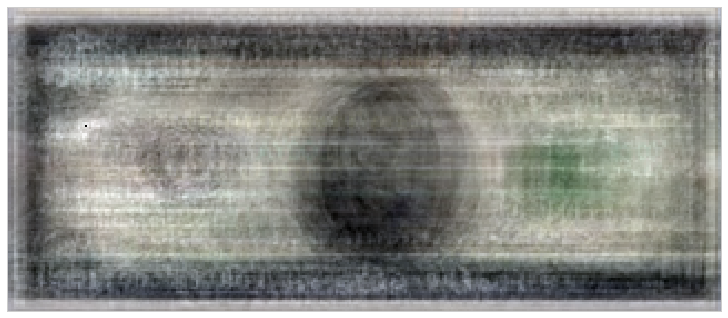

In [48]:
display_component(pca,0)

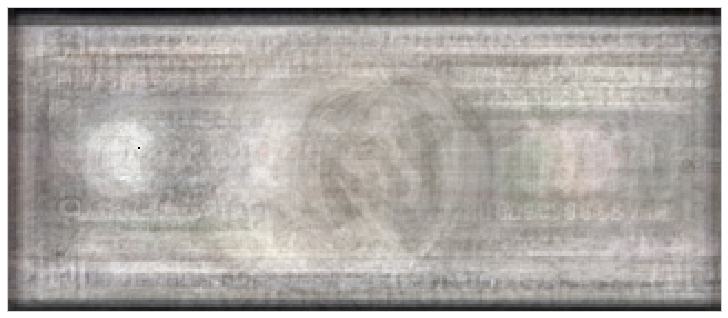

In [49]:
display_component(pca,1)

We take the first two principal components and immediately notice in the diagram below that they are enough to separate out the checks and the dollars. Indeed the first component itself seems to be mostly enough. We can look at the image of the first component and speculate that the medallion in the middle of the dollars probably contributes to this.

check
dollar


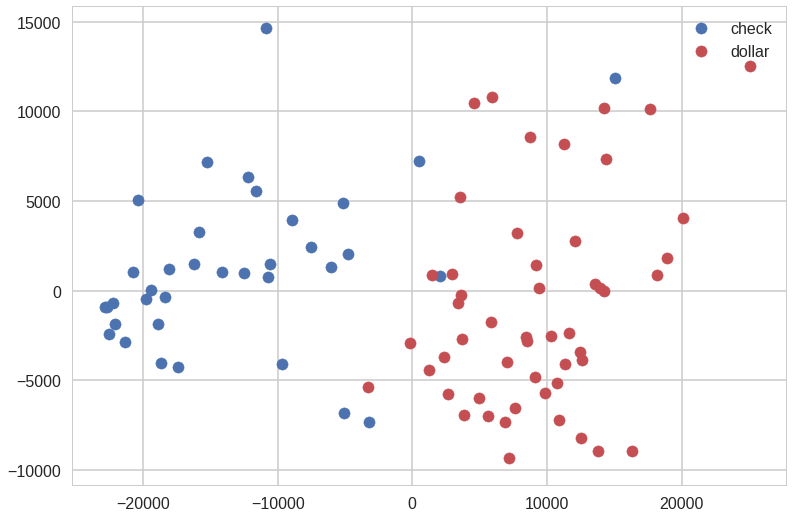

In [44]:
colors = [c0, c2]
for label, color in zip(df['label'].unique(), colors):
    print label
    mask = df['label']==label
    plt.scatter(df[mask]['pc1'], df[mask]['pc2'], c=color, label=label)
plt.legend()
plt.show()

You might be a bit confused: we needed to use 60 components to explain 94% of the variation in the features, but only 1 or 2 components to separate checks from dollars? This is because PCA is unsupervised: the only variation we are explaining is the variation in the 136452 dimensional feature space. We are not explaining the variation in the $y$ or the label, and it might turn out, as it does in this case, that with the additional information in $y$, the dimensionality needed for classification is much lower.

We could thus choose just the first few principal components to make our classifier. For the purposes of this lab, since two components can be easily visualized (even though adding some fore features may leads to better separability), we'll go with learning a 2-dimensional classifier in the `pc1` and `pc2` dimensions! [^By the way, there is a problem with pre-doing feature selection before doing cross-validation. Ideally one should be doing the feature selection separately in each fold. The reasons for this is basically that there is a high probability that a feature correlates strongly with $y$ just by chance, if there are so many features. How to do this properly will become clear in the homework.]

##Classifying in a reduced feature space with kNN

![m:knn1](images/knn1.png)

Implicit in the notion of classification, is the idea that samples close to each other in feature-space share a label. kNN is a very simple algorithm to diretly use this idea to do classification. The basic notion is this: if a lot of samples in some area of the feature space belong to one class as compared to the other, we'll label that part of the feature space as "belonging" to that class. This process will then classify the feature space into class-based regions. Then, given the point in feature space, we find which region its in and thus its class. 

The way kNN does this is to ask for the k nearest neighbors in the training set of the new sample. To answer this question, one must define a distance in the feature space (Note that this distance is different from the error or risk measures we have seen earlier). This distance is typically defined as the **Euclidean distance**, the sum of the square of the difference of each feature value between any two samples.

$$D(s_1,s_2) = \sum_f (x_{f1} - x_{f2})^2.$$

Once we have a distance measure, we can sort the distances from the current sample. Then we choose the $k$ closest ones in the training set, where $k$ is an odd number (to break ties) like 1,3,5,...19,. We now see how many of these $k$ "nearest neighbors" belong to one class or the other, and choose the majority class amongst those neighbors as our sample's class.

The training process thus simply consists of memorizing the data, perhaps using a database to aid in the fast lookup of the $k$ nearest training set neighbors of any point in feature space. Notice that this process divides feature space into regions of one class or the other, since one can simply ask what the $k$ nearest neighbors in the training set are of any given point in feature space. Also notice that since classification happens via a majority "voting" scheme, we also know the probability that a point in feature space belongs to a class, as estimated by the fraction of $k$ nearest neighbors to that point in the desired class.

Thanks to `sklearn`'s simple api, the classifier is really simple to write:

In [45]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
ys=df['y'].astype(int).values
subdf=df[['pc1','pc2']]
subdfstd=(subdf - subdf.mean())/subdf.std()
Xs=subdfstd.values
def classify(X,y, nbrs, plotit=True, train_size=0.6):
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size)
    clf= KNeighborsClassifier(nbrs)
    clf=clf.fit(Xtrain, ytrain)
    #in sklearn accuracy can be found by using "score". It predicts and then gets the accuracy
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    Xall=np.concatenate((Xtrain, Xtest))
    if plotit:
        print "Accuracy on training data: %0.2f" % (training_accuracy)
        print "Accuracy on test data:     %0.2f" % (test_accuracy)
        plt.figure()
        ax=plt.gca()
        points_plot(ax, Xtrain, Xtest, ytrain, ytest, clf, alpha=0.3, psize=20)
    return nbrs, training_accuracy, test_accuracy

Lets see what happens when we choose $k=1$. On the training set, the 1NN classifier memorizes the training data. It will predict perfectly on the training set, and wont do too badly on the test set, especially deep in the regions of feature space where one or the other class dominates. This is because evem one neighbor might be enough in those regions. However, the same classifier will do badly near the clasification boundaries on the test set, because you will need more than one neighbor to decide with any certainty of the class.

The result of this is, as you might expect, the regions of feature space classfied one way or the other (blue is check, red is dollar) are quite jagged and mottled. Since we are choosing just one neighbor, we fit to the noise in the region rather than the trend. We are overfitting.

Accuracy on training data: 1.00
Accuracy on test data:     0.91


(1, 1.0, 0.91428571428571426)

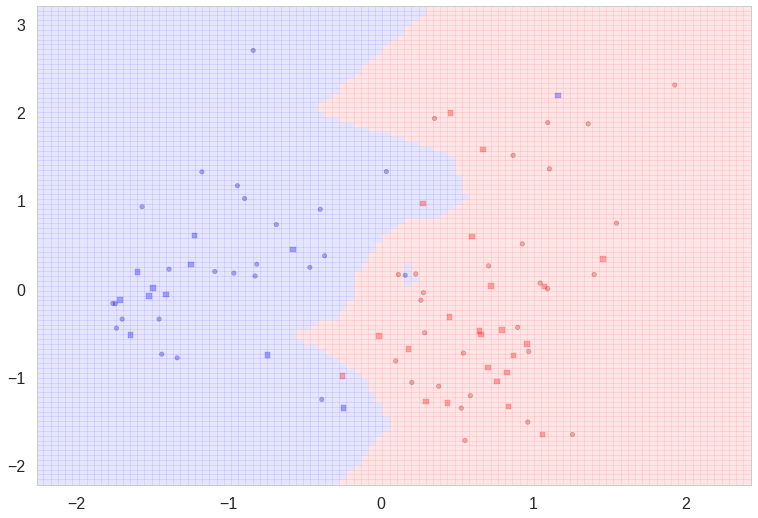

In [50]:
classify(Xs,ys,1)

If we choose too large a number for $k$, such as 50, we are wandering too far from our original sample,and thus we average over a large amount of the feature space. This leads to a very biased classification, depending on where our sample is, but extending far out from there. Our classification may even cover the entire feature space, then giving us the majority class.

In terms of probabilities, such an underfit case gives us the **base rate** classifier. Imagine $k=N$. Then the probability is just the fraction of training set examples in a given class. Say this number for the blue class is 0.4 (that is, whe have uneven class memberships in the training set). Now, on any random test set, if we use the classifier which says "classify all as red", we will be correct, on average, 60% of the time if the test set and training sets are representative of the population of samples. Any classifier we create must do a better job than this!

Accuracy on training data: 0.62
Accuracy on test data:     0.54


(50, 0.61538461538461542, 0.54285714285714282)

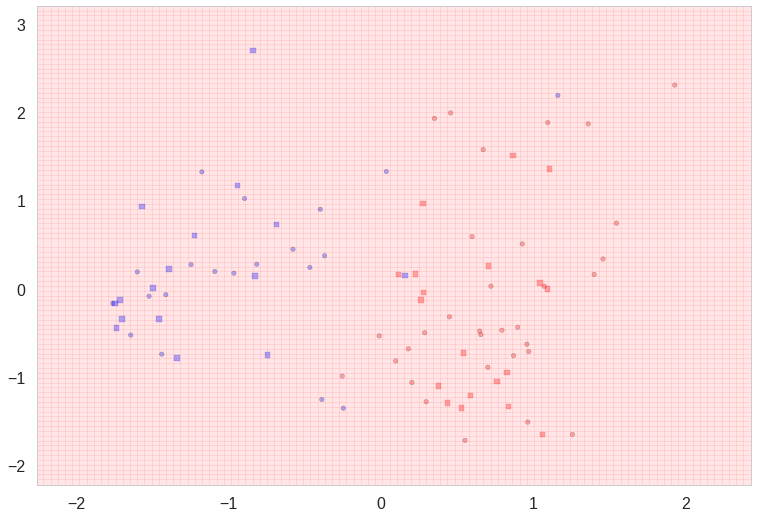

In [54]:
classify(Xs,ys,50)#run this a few times

![m:knn2](images/knn2.png)

These notions of overfitting and underfitting are illustrated in the image above: the small circles represent small $k$ neighborhoods while the large circle indicates a large $k$ neighborhood. The lower left part of that circle would likely be classified red even though it would seem to be visually more on the blue side of things.

The circle of in-between size illustrates what a reasonable $k$ might do. Also notice that kNN will be quite stable far away from the classification bondary, but is likely to be more jagged near the classification boundary. Having a reasonable number for $k$ will "smooth" the jaged edges out.

We thus once again need to find the balance between the high bias (large $k$) case and the high variance (low $k$) case, and once again we turn to our error vs complexity curve to find the appropriate $k$,

###Error against complexity (k), and cross-validation

In [55]:
fits={}
for k in np.arange(1,45,1):
    fits[k]=[]
    for i in range(200):
        fits[k].append(classify(Xs, ys,k, False))
nbrs=np.arange(1,45,1)
fmeanstr = np.array([1.-np.mean([t[1] for t in fits[e]]) for e in nbrs])
fmeanste = np.array([1.-np.mean([t[2] for t in fits[e]]) for e in nbrs])
fstdsstr = np.array([np.std([t[1] for t in fits[e]]) for e in nbrs])
fstdsste = np.array([np.std([t[2] for t in fits[e]]) for e in nbrs])

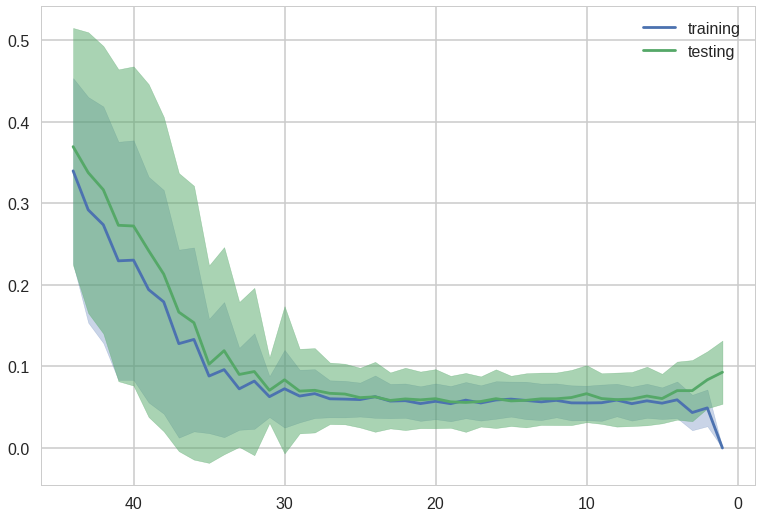

In [56]:
plt.gca().invert_xaxis()
plt.plot(nbrs, fmeanstr, color=c0, label="training");
plt.fill_between(nbrs, fmeanstr - fstdsstr, fmeanstr+fstdsstr, color=c0, alpha=0.3)
plt.plot(nbrs, fmeanste, color=c1, label="testing");
plt.fill_between(nbrs, fmeanste - fstdsste, fmeanste+fstdsste, color=c1, alpha=0.5)

plt.legend();

Once again, as before, we plot the test error and training errors against the number of neighbors $k$ . Here $k$ serves as a complexity parameter, with small $k$ being more "wiggly" in the classification of neighborhoods and large $k$ oversmoothing the classification. Notice that we plot $k$ reversed on the x-axis so as to go from lower complexity to higher complexity. As expected, the training error drops with complexity, but the test error starts going back up. There is a large range of $k$ from 25 to 5, in which the fit is as good as it gets!

###Setting up some code

Lets make a small diversion, though, and set some code up for classification using cross-validation so that we can easily run classification models in scikit-learn. We first set up a function `cv_optimize` which takes a classifier `clf`, a grid of hyperparameters (such as a complexity parameter or regularization parameter as in the last ) implemented as a dictionary `parameters`, a training set (as a samples x features array) `Xtrain`, and a set of labels `ytrain`. The code takes the traning set, splits it into `n_folds` parts, sets up `n_folds` folds, and carries out a cross-validation by splitting the training set into a training and validation section for each foldfor us. It prints the best value of the parameters, and retuens the best classifier to us.

In [32]:
def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=5):
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(Xtrain, ytrain)
    print "BEST PARAMS", gs.best_params_
    best = gs.best_estimator_
    return best

We then use this best classifier to fit the entire training set. This is done inside the `do_classify` function which takes a dataframe `indf` as input. It takes the columns in the list `featurenames` as the features used to train the classifier. The column `targetname` sets the target. The classification is done by setting those samples for which `targetname` has value `target1val` to the value 1, and all others to 0. We split the dataframe into 80% training and 20% testing by default, standardizing the dataset if desired. (Standardizing a data set involves scaling the data so that it has 0 mean and is described in units of its standard deviation. We then train the model on the training set using cross-validation. Having obtained the best classifier using `cv_optimize`, we retrain on the entire training set and calculate the training and testing accuracy, which we print. We return the split data and the trained classifier.

In [33]:
from sklearn.cross_validation import train_test_split
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, standardize=False, train_size=0.8):
    subdf=indf[featurenames]
    if standardize:
        subdfstd=(subdf - subdf.mean())/subdf.std()
    else:
        subdfstd=subdf
    X=subdfstd.values
    y=(indf[targetname].values==target1val)*1
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size)
    clf = cv_optimize(clf, parameters, Xtrain, ytrain)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    return clf, Xtrain, ytrain, Xtest, ytest

###As before, cross-validation

Lets repeat what we have been doing so far and carry out a cross-validation. We're of-course now training on an even smaller set, so our results will be a bit different from the diagram above. We plot the results in the diagram below. The results are fairly stable and correspond to our intuition that the first principal component basically separates the data.

In [34]:
bestcv, Xtrain, ytrain, Xtest, ytest = do_classify(KNeighborsClassifier(), {"n_neighbors": range(1,40,2)}, df, ['pc1','pc2'], 'label', 'check' )

BEST PARAMS {'n_neighbors': 3}
Accuracy on training data: 0.97
Accuracy on test data:     0.89


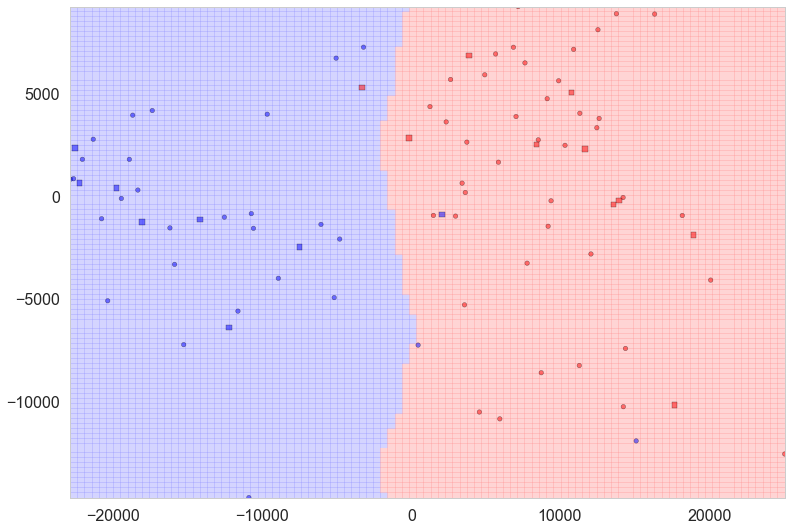

In [35]:
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, bestcv, alpha=0.5, psize=20);

We can plot the probability contours as well: the probability is easily obtained by just counting the fraction of neighbors that are blue or red.

//anaconda/lib/python2.7/site-packages/matplotlib/text.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if rotation in ('horizontal', None):
//anaconda/lib/python2.7/site-packages/matplotlib/text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':


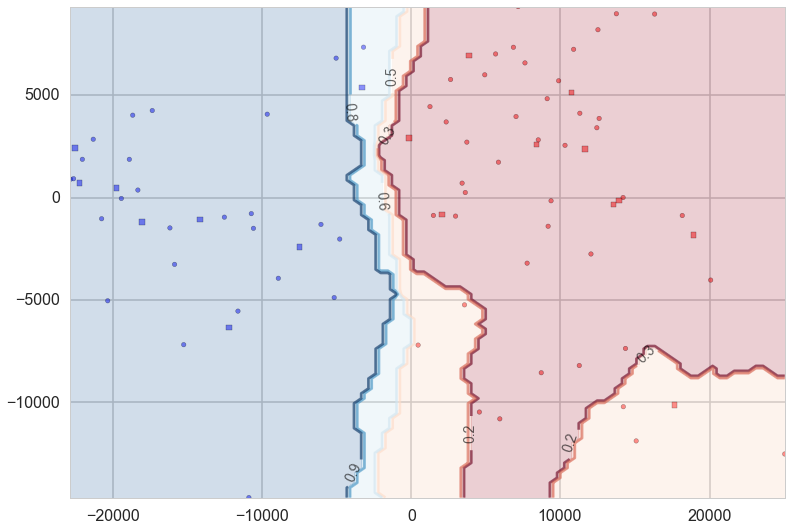

In [36]:
plt.figure()
ax=plt.gca()
points_plot_prob(ax, Xtrain, Xtest, ytrain, ytest, bestcv, alpha=0.5, psize=20);

####Evaluation

In [37]:
from sklearn.metrics import confusion_matrix, classification_report
confusion_matrix(ytest, bestcv.predict(Xtest), )

array([[9, 1],
       [1, 7]])


You have encountered nearest neighbor classifiers on the web before. They are components in the systems companies like Amazon, Netflix, and Yelp use when they tell you: if you liked movie A and movie B, you might like movie C. Later in the homework we shall use the Yelp data to create a restaurant recommender using kNN.

A critical part of writing such classifiers is finding the right features, since irrelevant features simply add additional noise into the distances in feature space. This is a particular form of the curse of dimensionality. Another way to deal with this problem is to assign greater weights to distances in certain dimensions, such as the "violentness" of a movie for example. Finally one may modify the voting mechanism or probability estimation for classifying from a simple majority class mechanism to one in which nearer examples in the k nearest examples are given more weight.



##Logistic Regression

Remember the 1-0 loss we talked about earlier? It turns out that minimizing the 1-0 loss with respect to some parameters of our model is very hard to do, for technical reasons of the 1-0 loss not being a convex loss (beyond the scope of this course). Thus it makes sense tolook for alternate approaches. One approach that we know about already is linear regression.

We could approach classification as linear regression, there the class, 0 or 1, is the target variable $y$. But this ignores the fact that our output $y$ is discrete valued, and futhermore, the $y$ predicted by linear regression will in general take on values less than 0 and greater than 1. Thus this does not seem like a very good idea.

But what if we could change the form of our hypotheses $h(x)$ instead?

The idea behind logistic regression is very simple. We want to draw a line in feature space that divides the '1' samples from the '0' samples, just like in the diagram above. In other words, we wish to find the "regression" line which divides the samples. Now, a line has the form $w_1 x_1 + w_2 x_2 + w_0 = 0$ in 2-dimensions. On one side of this line we have 

$$w_1 x_1 + w_2 x_2 + w_0 \ge 0,$$

and on the other side we have 

$$w_1 x_1 + w_2 x_2 + w_0 < 0.$$ 

Our classification rule then becomes:

\begin{eqnarray*}
y = 1 &if& \v{w}\cdot\v{x} \ge 0\\
y = 0 &if& \v{w}\cdot\v{x} < 0
\end{eqnarray*}

where $\v{x}$ is the vector $\{1,x_1, x_2,...,x_n\}$ where we have also generalized to more than 2 features.

What hypotheses $h$ can we use to achieve this? One way to do so is to use the **sigmoid** function:

$$h(z) = \frac{1}{1 + e^{-z}}.$$

Notice that at $z=0$ this function has the value 0.5. If $z > 0$, $h > 0.5$ and as $z \to \infty$, $h \to 1$. If $z < 0$, $h < 0.5$ and as $z \to -\infty$, $h \to 0$. As long as we identify any value of $y > 0.5$ as 1, and any $y < 0.5$ as 0, we can achieve what we wished above.

This function is plotted below:

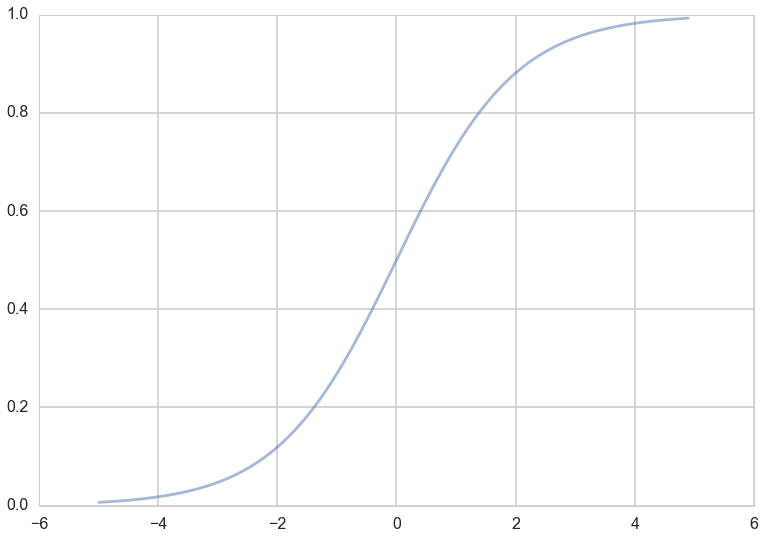

In [38]:
h = lambda z: 1./(1+np.exp(-z))
zs=np.arange(-5,5,0.1)
plt.plot(zs, h(zs), alpha=0.5);

So we then come up with our rule by identifying:

$$z = \v{w}\cdot\v{x}.$$

Then $h(\v{w}\cdot\v{x}) \ge 0.5$ if $\v{w}\cdot\v{x} \ge 0$ and $h(\v{w}\cdot\v{x}) \lt 0.5$ if $\v{w}\cdot\v{x} \lt 0$, and:

\begin{eqnarray*}
y = 1 &if& h(\v{w}\cdot\v{x}) \ge 0.5\\
y = 0 &if& h(\v{w}\cdot\v{x}) \lt 0.5.
\end{eqnarray*}

We will show soon that this identification can be achieved by minimizing a loss in the ERM framework called the **log loss** :

$$ R_{\cal{D}}(\v{w}) = - \sum_{y_i \in \cal{D}} \left ( y_i log(h(\v{w}\cdot\v{x})) + ( 1 - y_i) log(1 - h(\v{w}\cdot\v{x})) \right )$$

More generally we add a regularization term (as in the ridge regression):

$$ R_{\cal{D}}(\v{w}) = - \sum_{y_i \in \cal{D}} \left ( y_i log(h(\v{w}\cdot\v{x})) + ( 1 - y_i) log(1 - h(\v{w}\cdot\v{x})) \right ) + \frac{1}{C} \v{w}\cdot\v{w},$$

where $C$ is the regularization strength (corresponding to $1/\alpha$ from the Ridge case), and smaller values of $C$ mean stronger regularization. As before, the regularization tries to prevent features from having terribly high weights, thus implementing a form of feature selection. 

How did we come up with this loss? We'll come back to that, but let us see how logistic regression works out. 


In [39]:
dflog.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


In [40]:
clf_l, Xtrain_l, ytrain_l, Xtest_l, ytest_l  = do_classify(LogisticRegression(), {"C": [0.01, 0.1, 1, 10, 100]}, dflog, ['Weight', 'Height'], 'Gender','Male')

BEST PARAMS {'C': 0.01}
Accuracy on training data: 0.92
Accuracy on test data:     0.92


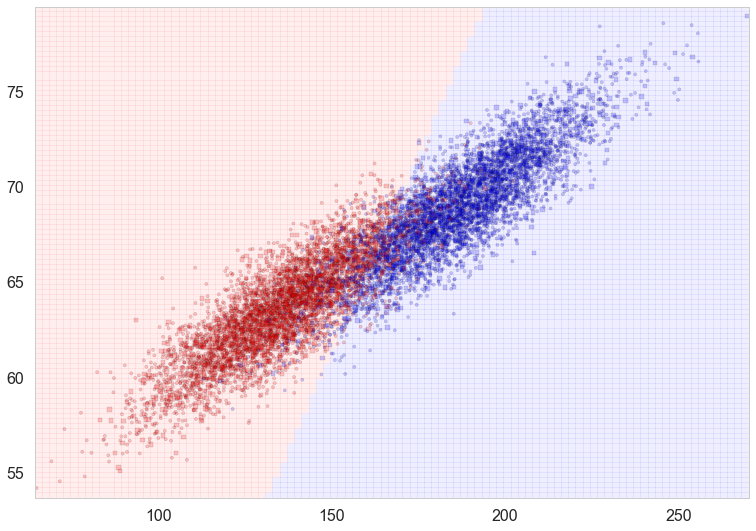

In [41]:
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain_l, Xtest_l, ytrain_l, ytest_l, clf_l, alpha=0.2);

In the figure here showing the results of the logistic regression, we plot the actual labels of both the training(circles) and test(squares) samples. The 0's (females) are plotted in red, the 1's (males) in blue. We also show the classification boundary, a line (to the resolution of a grid square). Every sample on the red background side of the line will be classified female, and every sample on the blue side, male. Notice that most of the samples are classified well, but there are misclassified people on both sides, as evidenced by leakage of dots or squares of one color ontothe side of the other color. Both test and traing accuracy are about 92%.

###The probabilistic interpretaion

Remember we said earlier that if $h > 0.5$ we ought to identify the sample with $y=1$? One way of thinking about this is to identify $h(\v{w}\cdot\v{x})$ with the probability that the sample is a '1' ($y=1$). Then we have the intuitive notion that lets identify a sample as 1 if we find that the probabilty of being a '1' is $\ge 0.5$.

So suppose we say then that the probability of $y=1$ for a given $\v{x}$ is given by $h(\v{w}\cdot\v{x})$?

Then, the conditional probabilities of $y=1$ or $y=0$ given a particular sample's features $\v{x}$ are:

\begin{eqnarray*}
P(y=1 | \v{x}) &=& h(\v{w}\cdot\v{x}) \\
P(y=0 | \v{x}) &=& 1 - h(\v{w}\cdot\v{x}).
\end{eqnarray*}

These two can be written together as

$$P(y|\v{x}, \v{w}) = h(\v{w}\cdot\v{x})^y \left(1 - h(\v{w}\cdot\v{x}) \right)^{(1-y)} $$

Then multiplying over the samples we get the probability of the training $y$ given $\v{w}$ and the $\v{x}$:

$$P(y|\v{x},\v{w}) = P(\{y_i\} | \{\v{x}_i\}, \v{w}) = \prod_{y_i \in \cal{D}} P(y_i|\v{x_i}, \v{w}) = \prod_{y_i \in \cal{D}} h(\v{w}\cdot\v{x_i})^{y_i} \left(1 - h(\v{w}\cdot\v{x_i}) \right)^{(1-y_i)}$$

Why use probabilities? Earlier, we talked about how the regression function $f(x)$ never gives us the $y$ exactly, because of noise. This hold for classification too. Even with identical features, a different sample may be classified differently. 

We said that another way to think about a noisy $y$ is to imagine that our data $\dat$ was generated from  a joint probability distribution $P(x,y)$. Thus we need to model $y$ at a given $x$, written as $P(y|x)$, and since $P(x)$ is also a probability distribution, we have:

$$P(x,y) = P(y | x) P(x) ,$$

and can obtain our joint probability ($P(x, y))$.

Indeed its important to realize that a particular training set can be thought of as a draw from some "true" probability distribution (just as we did when showing the hairy variance diagram). If for example the probability of classifying a test sample as a '0' was 0.1, and it turns out that the test sample was a '0', it does not mean that this model was necessarily wrong. After all, in roughly a 10th of the draws, this new sample would be classified as a '0'! But, of-course its more unlikely than its likely, and having good probabilities means that we'll be likely right most of the time, which is what we want to achieve in classification. And furthermore, we can quantify this accuracy.

Thus its desirable to have probabilistic, or at the very least, ranked models of classification where you can tell which sample is more likely to be classified as a '1'. There are business reasons for this too. Consider the example of customer "churn": you are a cell-phone company and want to know, based on some of my purchasing habit and characteristic "features" if I am a likely defector. If so, you'll offer me an incentive not to defect. In this scenario, you might want to know which customers are most likely to defect, or even more precisely, which are most likely to respond to incentives. Based on these probabilities, you could then spend a finite marketing budget wisely.

###Maximizing the probability of the training set.

Now if we maximize $$P(y|\v{x},\v{w})$$, we will maximize the chance that each point is classified correctly, which is what we want to do. While this is not exactly the same thing as maximizing the 1-0 training risk, it is a principled way of obtaining the highest probability classification. This process is called **maximum likelihood** estimation since we are maximising the **likelihood of the training data y**, 

$$\like = P(y|\v{x},\v{w}).$$ 

Maximum likelihood is one of the corenerstone methods in statistics, and is used to estimate probabilities of data. 

We can equivalently maximize 

$$\loglike = log(P(y|\v{x},\v{w}))$$ 

since the natural logarithm $log$ is a monotonic function. This is known as maximizing the **log-likelihood**. Thus we can equivalently *minimize* a risk that is the negative of  $log(P(y|\v{x},\v{w}))$:

$$R_{\cal{D}}(h(x)) = -\loglike = -log \like = - log(P(y|\v{x},\v{w})).$$


Thus

\begin{eqnarray*}
R_{\cal{D}}(h(x)) &=& -log\left(\prod_{y_i \in \cal{D}} h(\v{w}\cdot\v{x_i})^{y_i} \left(1 - h(\v{w}\cdot\v{x_i}) \right)^{(1-y_i)}\right)\\
                  &=& -\sum_{y_i \in \cal{D}} log\left(h(\v{w}\cdot\v{x_i})^{y_i} \left(1 - h(\v{w}\cdot\v{x_i}) \right)^{(1-y_i)}\right)\\                  
                  &=& -\sum_{y_i \in \cal{D}} log\,h(\v{w}\cdot\v{x_i})^{y_i} + log\,\left(1 - h(\v{w}\cdot\v{x_i}) \right)^{(1-y_i)}\\
                  &=& - \sum_{y_i \in \cal{D}} \left ( y_i log(h(\v{w}\cdot\v{x})) + ( 1 - y_i) log(1 - h(\v{w}\cdot\v{x})) \right )
\end{eqnarray*}
                  
This is exactly the risk we had above, leaving out the regularization term (which we shall return to later) and was the reason we chose it over the 1-0 risk. 

Notice that this little process we carried out above tells us something very interesting: **Probabilistic estimation using maximum likelihood is equivalent to Empiricial Risk Minimization using the negative log-likelihood**, since all we did was to minimize the negative log-likelihood over the training samples.

`sklearn` will return the probabilities for our samples, or for that matter, for any input vector set $\{\v{x}_i\}$, i.e. $P(y_i | \v{x}_i, \v{w})$:

In [42]:
clf_l.predict_proba(Xtest_l)

array([[  2.67350282e-01,   7.32649718e-01],
       [  9.65343424e-01,   3.46565764e-02],
       [  3.46984634e-04,   9.99653015e-01],
       ..., 
       [  9.99389269e-01,   6.10731300e-04],
       [  2.94057362e-01,   7.05942638e-01],
       [  3.75445124e-01,   6.24554876e-01]])

###Discriminative classifier

Logistic regression is what is known as a **discriminative classifier**. Let us plot the probabilities obtained from `predict_proba`, overlayed on the samples with their true labels:

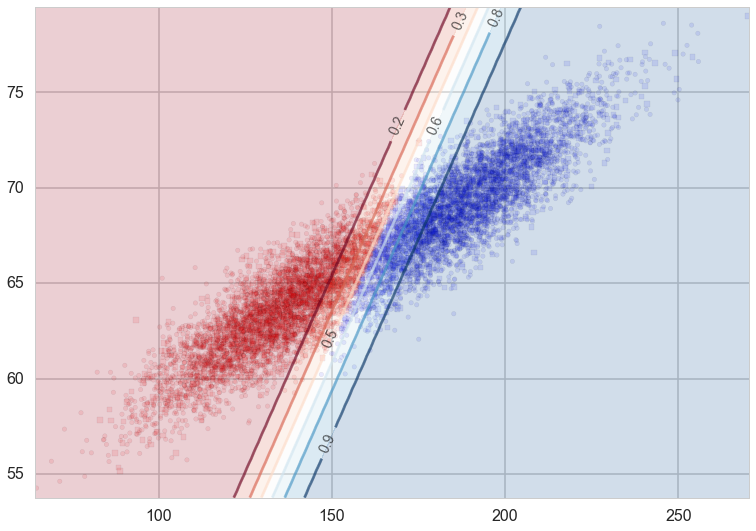

In [43]:
plt.figure()
ax=plt.gca()
points_plot_prob(ax, Xtrain_l, Xtest_l, ytrain_l, ytest_l, clf_l, psize=20, alpha=0.1);

Notice that lines of equal probability, as might be expected are stright lines. What the classifier does is very intuitive: if the probability is greater than 0.5, it classifies the sample as type '1' (male), otherwise it classifies the sample to be class '0'. Thus in the diagram above, where we have plotted predicted values rather than actual labels of samples, there is a clear demarcation at the 0.5 probability line.

This notion of trying to obtain the line or boundary of demarcation is what is called a **discriminative** classifier. The algorithm tries to find a decision boundary that separates the males from the females. To classify a new sample as male or female, it checks on which side of the decision boundary the sample falls, and makes a prediction. In other words we are asking, given $\v{x}$, what is the probability of a given $y$, or, what is the likelihood $P(y|\v{x},\v{w})$?

##The multiple risks in classification

With all this talk about probabilities, maximizing likelihood, and negative log-likelihoods as equivalent risks, you might be wondering if we have bitten the shark. Our original premise was a very simple empirical risk minimization (ERM). We just took all the points in the training or test set, and summed up the risk over them, dividing by the number of points in the set. Here we seem to be talking about solving a much harder problem, the estimation of probabilities.

We have some flavor of this simple minimization in this discriminative approach, since we do use ERM on the training set with the negatice log-likelihood as the risk. But we appear to have lost the direct notion of function estimation that we had proposed in the regression case. Instead we are indulging in probability estimation with a notion that a probability > 0.5 (in the two class case) is the key to making a classification.

Probability comes in because of stochastic noise and our incomplete knowledge about the world. Minimizing risk is an idea which works (as we saw in the noiseless regression case) even without any stochastic noise. Where do these two ideas meet? 

We minimized a risk (maximised likelihood) to estimate probability in both Logistic Regression (log-loss) and LDA above. This risk is called the **Estimation Risk**. But there is a second risk lurking here: one we call the **Decision Risk**. The final result we desire is not a list of probabilities; but rather a **decision**-making process on how to classify a given sample. The decision risk converts these probabilities into classifications. For example, we make an intuitive decision to classify a sample as a '1' if the probability of the sample being a '1' is greater than 0.5. It turns out that this intution actually uses the 1-0 risk we introduced earlier as a decision risk, as we shall show in the next . 

Why is separating the decision making process from the probability estimation process important? Consider as another example the case of predicting cancer based on features obtained from some tests, mammograms, etc. We dont want to predict a no-cancer for someone who has it (if we consider cancer as class '1', the positive class, this would be a false negative). This might be a death sentence (not to mention the liability lawsuit). The opposite, predicting cancer for someone who dosent have it (a false positive) is not as bad, obviously. Now the threshold probability for choosing '1' ought to be lower than 0.5, as we ought to be predicting "cancer" at even the whiff of it. This is **asymmetric risk**: we'll show in the next  that we need to modify the 1-0 risk to account for this *decision making asymmetry*.

Thus we need to consider *two risks in learning*, one to *estimate probabilities*, and one to *make decisions*. We shall delve into this in more detail in the next lab.

##Discriminants: sometime there is no probabilities

Sometimes, however, in the learning process, there might be no probabilities. In this case, we want to directly find a decision boundary by using only a decision risk. Such a classifier which directly models a **decision boundary** is called a **discriminant classifier**, as opposed to a discriminative classifier. Examples are the Perceptron and the SVM.

Consider the example shown in the figure below. In the upper left panel, we have a line separating two classes of data. Notice, however, from the upper right panel that this line is not unique. Which one to choose?

Logistic Regression answers this question based on minimizing the log loss or modelling $P(\v{x} |y)$ directly (we havent talked yet about how the latter is estimated, we shall come to this shortly). One other way to think about this, though, is to ask the question: what is the maximum margin around the lines that can be drawn. We ask this question in the bottom left panel, and see that one of the lines (not our original line) is the one that has a maximum margin around it, so that the margin just touches samples of either class.

This kind of classifier is called a maximum-margin classifier. There is no a-priori probabilistic interpretation of this model. Historically, it came directly out of empirical risk minimization (Vapnik, Vladimir. "Principles of risk minimization for learning theory." Advances in neural information processing systems. 1992., http://www.mit.edu/~6.454/www_spring_2001/emin/slt.pdf, Vapnik, Vladimir. The nature of statistical learning theory. Springer Science & Business Media, 2013.). The advantages of this model can be seen visually: a larger margin is more robust. Further, the model works where its needed the hardest: it is sensitive to the boundary between the classes, rather than the points samples deep in feature space inside a specific class. 

![Different modes of separation](images/linsep.png)

The most famous example of a discriminant classifier is one you have probably heard of: the Support Vector Machine (SVM). The SVM is illustrated in the bottom right panel. It finds the widest possible margin such that there might be points touching the boundary: these points are called the support vectors: you can think of them as holding up or supporting the margins.

The support vector machine works by minimizing a *decision risk* called the **hinge-loss**, which does not have a probabilistic interpretation such as the maximum-likelihood interpretation of Logistic Regression's log-loss. While later research(Wu, Lin and Weng, “Probability estimates for multi-class classification by pairwise coupling”. JMLR 5:975-1005, 2004.) has retrofitted probability models (very expensive) onto the SVM, the original SVM was concieved as a non-probabilistic model driven by the ERM school of learning (see Vapnik references above). 

Currently, however, we seem to be missing the answer to possibly the most important question: how did out classifier do? This is the subject of **Decision Theory**. In the next lab, lets get to it!